In [1]:
import lsdb
import numpy as np
from astropy.timeseries import LombScargle
from dask.distributed import Client

In [2]:
catalog = lsdb.open_catalog(
    "https://data.lsdb.io/hats/ztf_dr22",
    search_filter=lsdb.ConeSearch(ra=254.5, dec=35.3, radius_arcsec=1800),
)
# Create "lc" column with light curves
catalog = catalog.nest_lists(
    list_columns=["hmjd", "mag", "magerr", "clrcoeff", "catflags"],
    name="lc",
)
catalog

Dask NestedFrame Structure:
                          objectid       filterid         fieldid           rcid           objra          objdec         nepochs          Norder              Dir             Npix                                                                                           lc
npartitions=1                                                                                                                                                                                                                                                                  
669347494617939968  int64[pyarrow]  int8[pyarrow]  int16[pyarrow]  int8[pyarrow]  float[pyarrow]  float[pyarrow]  int64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  nested<hmjd: [double], mag: [float], magerr: [float], clrcoeff: [float], catflags: [int32]>
669628969594650624             ...            ...             ...            ...             ...             ...             ...             ...              ...              ...                                                                                          ...
Dask Name: lambda, 6 expressions
Expr=MapPartitions(lambda)

Now we filter by observational conditions using "catflags" column nested into the top-level "lc" column.
Also let's say that we are interested in "r"-band (filterid 2) light curves only.

We can use both pandas' indexing interface with `[]` and `.query` method

In [3]:
filtered_catalog = catalog.query("filterid == 2")
filtered_catalog = filtered_catalog.query("lc.catflags == 0")
# Now we may have some empty light curves - let's remove them
filtered_catalog = filtered_catalog.dropna(subset=["lc"])
filtered_catalog

Dask NestedFrame Structure:
                          objectid       filterid         fieldid           rcid           objra          objdec         nepochs          Norder              Dir             Npix                                                                                           lc
npartitions=1                                                                                                                                                                                                                                                                  
669347494617939968  int64[pyarrow]  int8[pyarrow]  int16[pyarrow]  int8[pyarrow]  float[pyarrow]  float[pyarrow]  int64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  nested<hmjd: [double], mag: [float], magerr: [float], clrcoeff: [float], catflags: [int32]>
669628969594650624             ...            ...             ...            ...             ...             ...             ...             ...              ...              ...                                                                                          ...
Dask Name: drop_na_part, 9 expressions
Expr=MapPartitions(drop_na_part)

Let's run some analysis code over the light curves.
First, we'll get the median magnitude, filter by it, and compute the best period with a Lomb–Scargle periodogram. Let's find an object with the period of 1.7 days.

We use `Catalog.reduce` method, which "reduces" each light curve to one or a few numbers.

In [4]:
catalog_w_features = filtered_catalog.reduce(
    # User-defined function, must output a dictionary of results
    lambda mag: {"median_mag": np.median(mag)},
    # Names of the columns to pass to the function
    "lc.mag",
    # This helps Dask to understand what are te data dtypes of the return values
    meta={"median_mag": float},
    append_columns=True,
)
catalog_w_features = catalog_w_features.query("median_mag < 16")


def extract_period(time, mag, error):
    # Ignore light curves with less than 10 detections:
    if len(time) < 10:
        return {"period": 0.0, "false_alarm_prob": 1.0}
    ls = LombScargle(time, mag, error)
    freq, power = ls.autopower()
    argmax = np.argmax(power)
    period = 1.0 / freq[argmax]
    false_alarm_prob = ls.false_alarm_probability(power[argmax])
    return {"period": period, "false_alarm_prob": false_alarm_prob}


catalog_w_features = catalog_w_features.reduce(
    # Function
    extract_period,
    # Column names specifying function arguments
    "lc.hmjd",
    "lc.mag",
    "lc.magerr",
    # Return data types
    meta={"period": float, "false_alarm_prob": float},
    append_columns=True,
)
catalog_w_features

Dask NestedFrame Structure:
                          objectid       filterid         fieldid           rcid           objra          objdec         nepochs          Norder              Dir             Npix                                                                                           lc median_mag   period false_alarm_prob
npartitions=1                                                                                                                                                                                                                                                                                                       
669347494617939968  int64[pyarrow]  int8[pyarrow]  int16[pyarrow]  int8[pyarrow]  float[pyarrow]  float[pyarrow]  int64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  nested<hmjd: [double], mag: [float], magerr: [float], clrcoeff: [float], catflags: [int32]>    float64  float64          float64
669628969594650624             ...            ...             ...            ...             ...             ...             ...             ...              ...              ...                                                                                          ...        ...      ...              ...
Dask Name: nestedframe, 14 expressions
Expr=MapPartitions(NestedFrame)

In [5]:
periodic_catalog = catalog_w_features.query("false_alarm_prob < 1e-10 and 1.6 < period < 1.8")
periodic_catalog

Dask NestedFrame Structure:
                          objectid       filterid         fieldid           rcid           objra          objdec         nepochs          Norder              Dir             Npix                                                                                           lc median_mag   period false_alarm_prob
npartitions=1                                                                                                                                                                                                                                                                                                       
669347494617939968  int64[pyarrow]  int8[pyarrow]  int16[pyarrow]  int8[pyarrow]  float[pyarrow]  float[pyarrow]  int64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  nested<hmjd: [double], mag: [float], magerr: [float], clrcoeff: [float], catflags: [int32]>    float64  float64          float64
669628969594650624             ...            ...             ...            ...             ...             ...             ...             ...              ...              ...                                                                                          ...        ...      ...              ...
Dask Name: lambda, 15 expressions
Expr=MapPartitions(lambda)

In [6]:
with Client(n_workers=2, threads_per_worker=1) as client:
    display(client)
    df = periodic_catalog.compute()
df

<Client: 'tcp://127.0.0.1:53519' processes=2 threads=2, memory=32.00 GiB>

objectid  filterid  fieldid  rcid      objra  \
_healpix_29                                                               
669411015865751384  680213300009232         2      680    50  254.45752   

                      objdec  nepochs  Norder  Dir  Npix  \
_healpix_29                                                
669411015865751384  35.34235     1403       5    0  2378   

                                                                   lc  \
_healpix_29                                                             
669411015865751384  [{hmjd: 58198.39511, mag: 14.103342, magerr: 0...   

                    median_mag    period  false_alarm_prob  
_healpix_29                                                 
669411015865751384   13.564873  1.700147               0.0

We see that we have a single object there! It is HZ Her, a bright X-ray binary system. Let's plot it

Text(0.5, 1.0, 'Object ID: 680213300009232, period: 1.700 d')

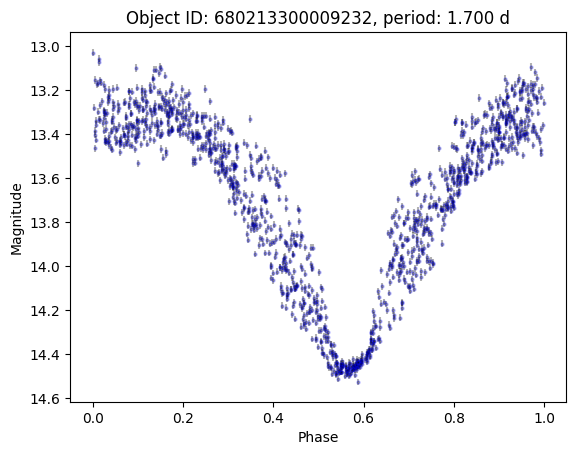

In [21]:
import matplotlib.pyplot as plt

row = df.iloc[0]
lc = row.lc

peak_mjd = lc["hmjd"][lc["mag"].idxmin()]
lc["phase"] = (lc["hmjd"] - peak_mjd) % row.period / row.period

plt.errorbar(
    lc["phase"],
    lc["mag"],
    lc["magerr"],
    alpha=0.3,
    ls="none",
    marker="o",
    markersize=2,
    markeredgecolor="blue",
    color="black",
)
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.title(f"Object ID: {row.objectid}, period: {row.period:.3f} d")